In [88]:
import requests
import pylab
import pandas as pd
from pymc import DiscreteUniform, Exponential, deterministic, Poisson, Uniform
import pymc3
import numpy as np
import io
import warnings
import sklearn
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

AttributeError: module 'theano' has no attribute 'gof'

In [4]:
csv = requests.get("https://opendata.arcgis.com/datasets/37abda537d17458bae6677b8ab75fcb9_0.csv").content
main_df = pd.read_csv(io.StringIO(csv.decode('utf-8')))

In [10]:
filt = main_df["Hospitalized"] == "YES"
df = main_df[filt]

In [11]:
df.loc[:,'EventDate'] = pd.to_datetime(df.loc[:,'EventDate'],format='%Y/%m/%d %H:%M:%S')
df.loc[:,"FormattedEventDate"] = df.loc[:,"EventDate"].dt.strftime("%m/%d/%Y")
df.loc[:,"EventDate"] = pd.to_datetime(df.loc[:,"FormattedEventDate"],format='%m/%d/%Y')
df = df.iloc[:,[0,1,2,3,7,8,9,13,16]]

In [12]:
hospitalized_df = df.groupby("EventDate").count().reset_index()[['EventDate','Hospitalized']]
df.groupby("EventDate").count()['Hospitalized'].tail(20)

EventDate
2020-06-27    271
2020-06-28    260
2020-06-29    319
2020-06-30    289
2020-07-01    320
2020-07-02    250
2020-07-03    232
2020-07-04    215
2020-07-05    205
2020-07-06    208
2020-07-07    213
2020-07-08    164
2020-07-09    173
2020-07-10    137
2020-07-11    109
2020-07-12    102
2020-07-13     93
2020-07-14     68
2020-07-15     43
2020-07-16      8
Name: Hospitalized, dtype: int64

In [49]:
hospitalization_array = df.groupby("EventDate").count()['Hospitalized']
hospitalization_array.dropna(inplace=True)

In [15]:
switchpoint = DiscreteUniform('switchpoint', lower=0, upper=110, doc='Switchpoint[year]')

In [16]:
early_mean = Exponential('early_mean', beta=1.)
late_mean = Exponential('late_mean', beta=1.)

In [32]:
@deterministic(plot=False)
def rate(s=switchpoint, e=early_mean, l=late_mean):
    ''' Concatenate Poisson means '''
    out = np.empty(len(hospitalization_array))
    out[:s] = e
    out[s:] = l
    return out

In [20]:
hospitalizations = Poisson('hospitalizations', mu=rate, value=hospitalization_array, observed=True)

In [33]:
hospitalizations

<pymc.distributions.new_dist_class.<locals>.new_class 'hospitalizations' at 0x000001103CFEBDD8>

In [42]:
def make_model(T):
    a = Uniform('a',-1,1)
    Tm = pm.Normal('T',mu=a, tau=1.0,value=T, observed = True)
    
    return locals()

m = pm.Model(make_model(hospitalization_array))

In [84]:
# Parameters for gaussian
amp_true = 0.2
size_true = 1.8
ps_true = 0.1

x = np.linspace(0,100)

f = hospitalization_array

# Gaussian function
gauss = lambda x,amp,size,ps: amp*np.exp(-1*(np.pi**2/(3600.*180.)*size*x)**2/(4.*np.log(2.)))+ps
f_true = gauss(x=x,amp=amp_true, size=size_true, ps=ps_true )

f_error = np.ones_like(f_true)*0.05*f.max()

# define the model/function to be fitted.
def model(x, f): 
    amp = pymc.Uniform('amp', 0.05, 0.4, value= 0.15)
    size = pymc.Uniform('size', 0.5, 2.5, value= 1.0)
    ps = pymc.Normal('ps', 0.13, 40, value=0.15)

    @pymc.deterministic(plot=False)
    def gauss(x=x, amp=amp, size=size, ps=ps):
        e = -1*(np.pi**2*size*x/(3600.*180.))**2/(4.*np.log(2.))
        return amp*np.exp(e)+ps
    y = pymc.Normal('y', mu=gauss, tau=1.0/f_error**2, value=f, observed=True)
    return locals()

MDL = pymc.MCMC(model(x,f))
MDL.sample(1e4)

# extract and plot results
y_min = MDL.stats()['gauss']['quantiles'][2.5]
y_max = MDL.stats()['gauss']['quantiles'][97.5]
y_fit = MDL.stats()['gauss']['mean']
plt.plot(x,f_true,'b', marker='None', ls='-', lw=1, label='True')
plt.errorbar(x,f,yerr=f_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x,y_fit,'k', marker='+', ls='None', ms=5, mew=2, label='Fit')
plt.fill_between(x, y_min, y_max, color='0.5', alpha=0.5)
plt.legend()

error: (nmu==1||nmu==n) failed for hidden nmu: normal:nmu=50

In [43]:
X = np.linspace(0,200)

<Figure size 432x288 with 0 Axes>

ValueError: array must not contain infs or NaNs

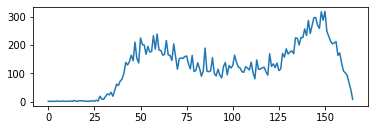

In [73]:
plt.figure(1)
plt.clf()
plt.show()

plt.subplot(2,1,1)
plt.plot(hospitalization_array)

N=pm.NormApprox(m)
N.fit()

In [72]:
hospitalization_array = np.nan_to_num(hospitalization_array)

In [74]:
hospitalization_array


array([  1,   1,   1,   1,   1,   2,   1,   1,   2,   1,   1,   1,   2,
         1,   4,   1,   2,   3,   3,   2,   2,   1,   1,   2,   3,   1,
         5,   2,  19,   9,   8,  18,  27,  24,  33,  19,  39,  62,  57,
        73,  80, 101, 139, 130, 142, 165, 145, 211, 154, 137, 226, 202,
       201, 168, 196, 176, 178, 234, 186, 240, 183, 182, 165, 167, 217,
       166, 164, 146, 205, 159, 115, 152, 155, 153, 160, 162, 134, 116,
       164, 107, 110, 138, 118,  90, 108, 190, 108, 106, 109, 156, 100,
        91, 115,  94,  84, 125, 139,  95, 128, 119, 128, 165, 140, 123,
       119, 106, 104, 124, 119, 112, 140, 103,  81, 148, 114, 116, 120,
       122, 106,  94, 170, 125, 134, 121, 137, 110, 116, 171, 158, 187,
       169, 176, 180, 170, 226, 225, 201, 228, 227, 258, 235, 288, 242,
       270, 298, 298, 271, 260, 319, 289, 320, 250, 232, 215, 205, 208,
       213, 164, 173, 137, 109, 102,  93,  68,  43,   8], dtype=int64)